<a href="https://colab.research.google.com/github/VincenteCodes/Loan-prediction/blob/main/Loan_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import useful libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as mso
import seaborn as sns
import warnings
import os
import scipy

from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

**Data Pre-processing (Exploratory Data Analysis)**

This section will perform data exploration of "raw" data set that has been imported.


In [ ]:
#load the data and look at the first 5 examples
df = pd.read_csv("https://raw.githubusercontent.com/VincenteCodes/Loan-prediction/main/Training%20Data.csv")
df.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


In [ ]:
print(df.shape)

(252000, 13)


As seen from above, the 13 columns are readable. It also can be seen that there are 252,000 observations in the data set.

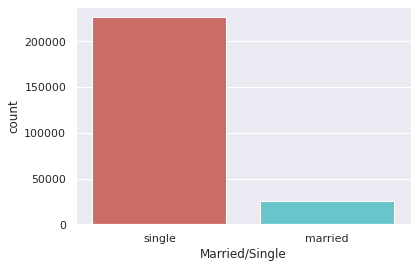

In [ ]:
sns.countplot(x="Married/Single", data=df, palette="hls")
plt.show()

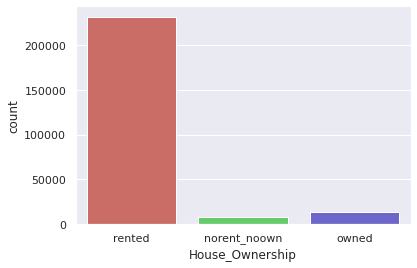

In [ ]:
sns.countplot(x="House_Ownership", data=df, palette="hls")
plt.show()

In [ ]:
#look for null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Id                 252000 non-null  int64 
 1   Income             252000 non-null  int64 
 2   Age                252000 non-null  int64 
 3   Experience         252000 non-null  int64 
 4   Married/Single     252000 non-null  object
 5   House_Ownership    252000 non-null  object
 6   Car_Ownership      252000 non-null  object
 7   Profession         252000 non-null  object
 8   CITY               252000 non-null  object
 9   STATE              252000 non-null  object
 10  CURRENT_JOB_YRS    252000 non-null  int64 
 11  CURRENT_HOUSE_YRS  252000 non-null  int64 
 12  Risk_Flag          252000 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 25.0+ MB


No null values were found

In [ ]:
countrented = len(df[df.House_Ownership == 'rented'])
countnorent_noown = len(df[df.House_Ownership == 'norent_noown'])
countowned = len(df[df.House_Ownership == 'owned'])
countNull = len(df[df.House_Ownership.isnull()])

print("Percentage of applicants who have a Rented apartment: {:.2f}%".format((countrented / (len(df.House_Ownership))*100)))
print("Percentage of applicants who neither own nor rent their house: {:.2f}%".format((countnorent_noown / (len(df.House_Ownership))*100)))
print("Percentage of aplicants who Own their house: {:.2f}%".format((countowned / (len(df.House_Ownership))*100)))
print("Missing values percentage: {:.2f}%".format((countNull / (len(df.House_Ownership))*100)))

Percentage of applicants who have a Rented apartment: 92.02%
Percentage of applicants who neither own nor rent their house: 2.85%
Percentage of aplicants who Own their house: 5.13%
Missing values percentage: 0.00%


From the above result, the number of applicants with a rented apartment is higher compared to applicants who own their houses and those who neither rent nor own their houses. It also can be seen there are no missing values in this column.

In [ ]:
df = df.apply(LabelEncoder().fit_transform);

In [ ]:
y = df.Risk_Flag
X = df.drop('Risk_Flag', axis=1)

In [ ]:
#Brief desciption of the data
df.describe()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
count,252000.000000,252000.000000,252000.000000,252000.000000,252000.000000,252000.000000,252000.000000,252000.000000,252000.000000,252000.000000,252000.000000,252000.000000,252000.000000
mean,125999.500000,20948.121405,28.954071,10.084437,0.897905,1.891722,0.301587,25.276746,158.137675,13.808952,6.333877,1.997794,0.123000
std,72746.278255,12087.301892,17.063855,6.002590,0.302774,0.391880,0.458948,14.728537,92.201736,9.372300,3.647053,1.399037,0.328438
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,62999.750000,10435.000000,14.000000,5.000000,1.000000,2.000000,0.000000,13.000000,78.000000,6.000000,3.000000,1.000000,0.000000
50%,125999.500000,21021.500000,29.000000,10.000000,1.000000,2.000000,0.000000,26.000000,157.000000,14.000000,6.000000,2.000000,0.000000
75%,188999.250000,31372.000000,44.000000,15.000000,1.000000,2.000000,1.000000,38.000000,238.000000,22.000000,9.000000,3.000000,0.000000
max,251999.000000,41919.000000,58.000000,20.000000,1.000000,2.000000,1.000000,50.000000,316.000000,28.000000,14.000000,4.000000,1.000000


DATA VISUALIZATION 

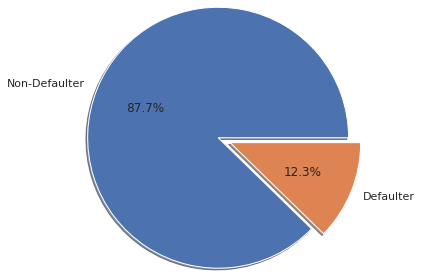

In [ ]:
#check for percentage of defualters in the data
r = df.groupby('Risk_Flag')['Risk_Flag'].count()

plt.pie(r, explode=[0.05, 0.1], labels=['Non-Defaulter', 'Defaulter'], radius=1.5, autopct='%1.1f%%', shadow=True);

From the chart, it shows only 12.3% are defaulters 

Histogram Distribution 📉

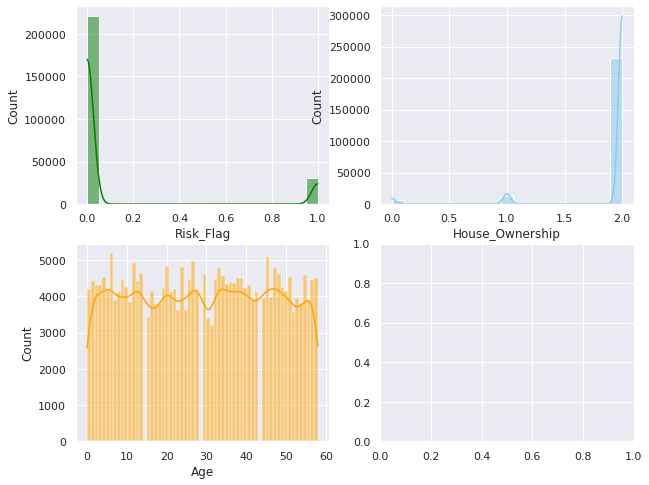

In [ ]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

sns.histplot(data=df, x="Risk_Flag", kde=True, ax=axs[0, 0], color='green')
sns.histplot(data=df, x="House_Ownership", kde=True, ax=axs[0, 1], color='skyblue')
sns.histplot(data=df, x="Age", kde=True, ax=axs[1, 0], color='orange');

Violin Plot 🎻

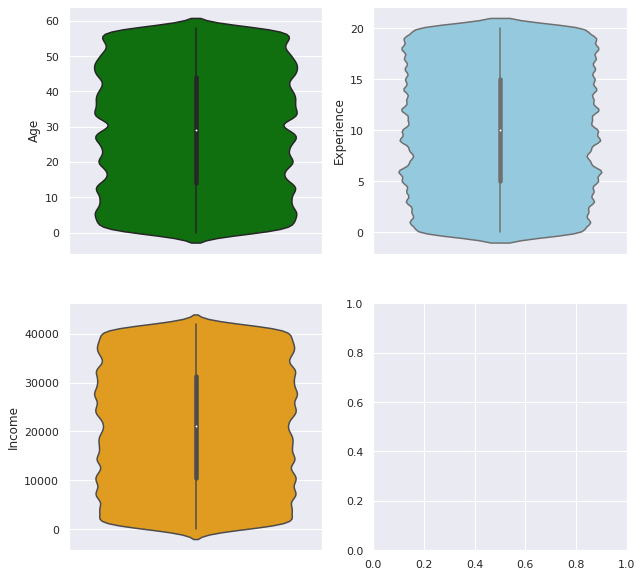

In [ ]:
sns.set(style="darkgrid")
fig, axs1 = plt.subplots(2, 2, figsize=(10, 10))

sns.violinplot(data=df, y="Age", ax=axs1[0, 0], color='green')
sns.violinplot(data=df, y="Experience", ax=axs1[0, 1], color='skyblue')
sns.violinplot(data=df, y="Income", ax=axs1[1, 0], color='orange');


*   The distribution of Applicant income, and Age are positively skewed and it has outliers (can be seen from both histogram and violin plot).



**Heatmap**

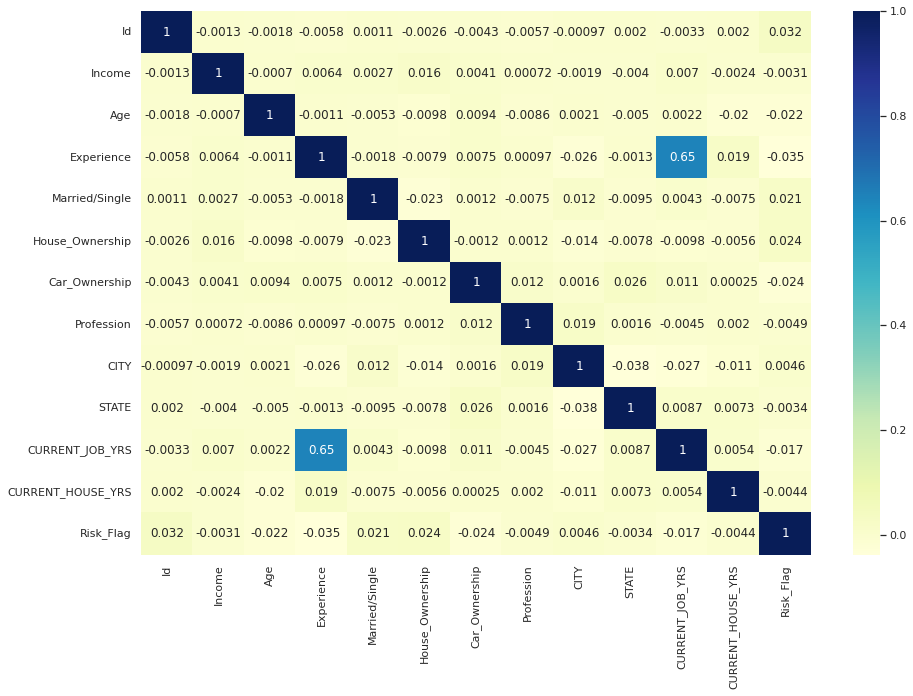

In [ ]:
#lets check for correlations between variables
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu")

From the above plot It looks like only Experience and CURRENT_JOB_YRS are slightly correlated

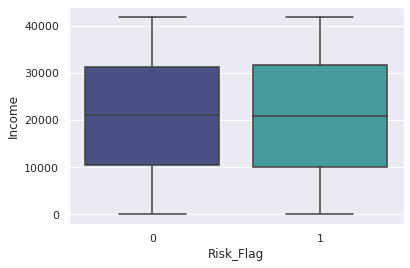

In [ ]:
sns.boxplot(x="Risk_Flag", y="Income", data=df, palette="mako");

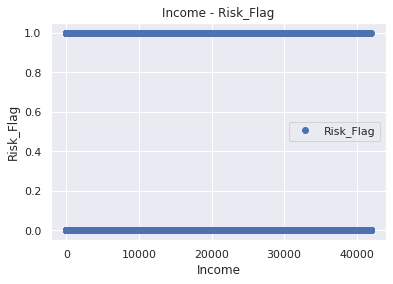

Pearson correlation: -0.0031071149785928255
T Test and P value: 
 Ttest_indResult(statistic=869.9883423466636, pvalue=0.0)


In [ ]:
df.plot(x='Income', y='Risk_Flag', style='o')  
plt.title('Income - Risk_Flag')  
plt.xlabel('Income')
plt.ylabel('Risk_Flag')  
plt.show()
print('Pearson correlation:', df['Income'].corr(df['Risk_Flag']))
print('T Test and P value: \n', stats.ttest_ind(df['Income'], df['Risk_Flag']))

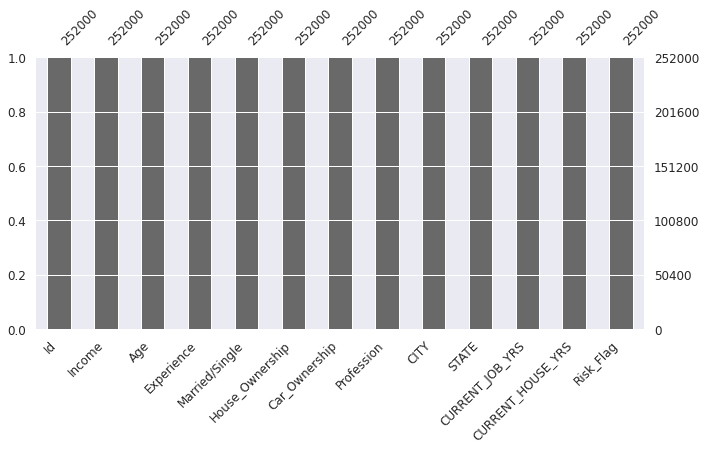

In [ ]:
plt.figure(figsize = (24, 5))
axz = plt.subplot(1,2,2)
mso.bar(df, ax = axz, fontsize = 12);

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


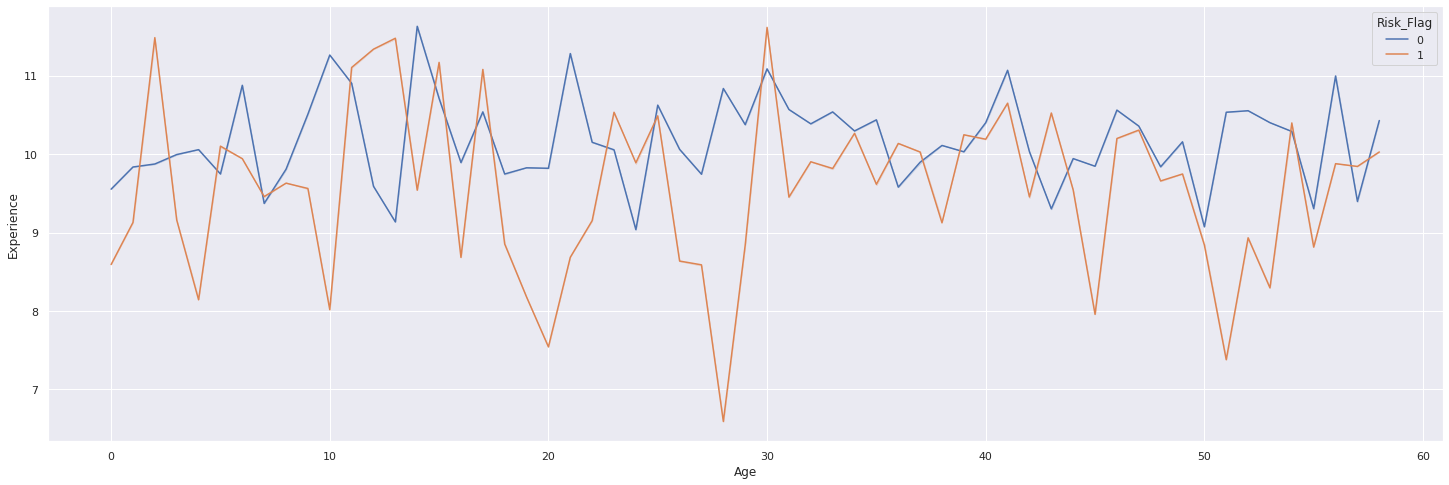

In [ ]:
plt.figure(figsize=(25,8))
sns.lineplot(df['Age'], df['Experience'], hue=df['Risk_Flag'],ci=0)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


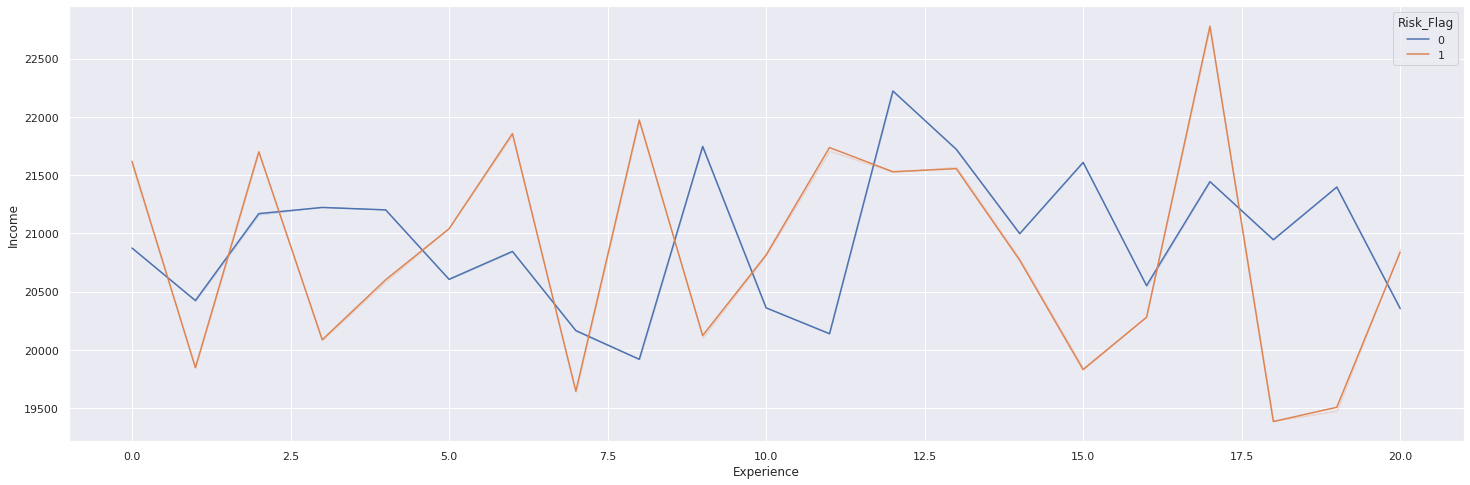

In [ ]:
plt.figure(figsize=(25,8))
sns.lineplot(df['Experience'], df['Income'], hue=df['Risk_Flag'],ci=0)

''

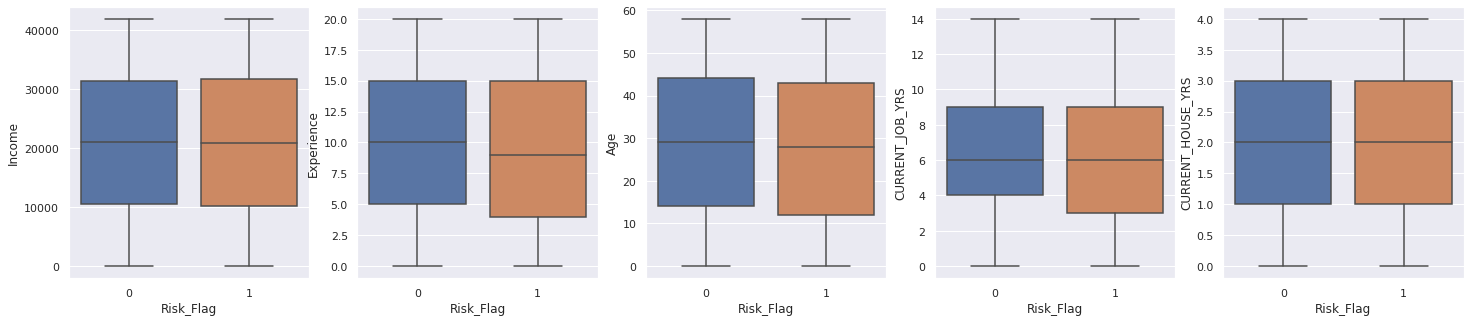

In [ ]:
f = plt.figure(figsize=(25,5))
ax = f.subplots(1, 5)
sns.boxplot(x='Risk_Flag', y='Income', data=df, ax=ax[0])
sns.boxplot(x='Risk_Flag', y='Experience', data=df, ax=ax[1])
sns.boxplot(x='Risk_Flag', y='Age', data=df, ax=ax[2])
sns.boxplot(x='Risk_Flag', y='CURRENT_JOB_YRS', data=df, ax=ax[3])
sns.boxplot(x='Risk_Flag', y='CURRENT_HOUSE_YRS', data=df, ax=ax[4])
;

We can't see any significant difference between defaulters and non-defaulters from Income, Experience, Age, CURRENT_JOB_YRS, CURRENT_HOUSE_YRS

Remove Outliers & Infinite values 🚮

In [ ]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

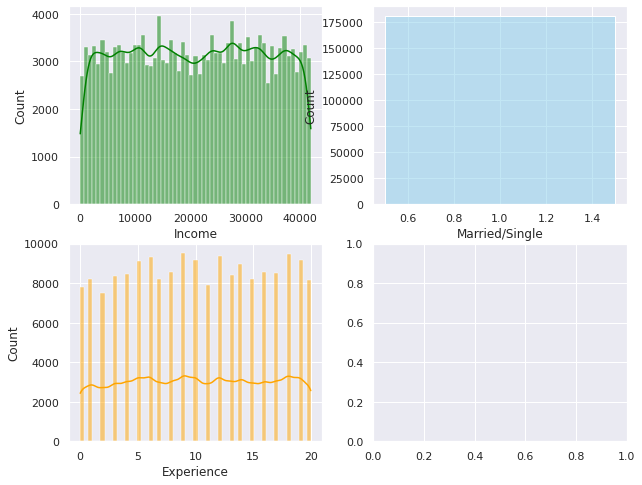

In [ ]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

sns.histplot(data=df, x="Income", kde=True, ax=axs[0, 0], color='green')
sns.histplot(data=df, x="Married/Single", kde=True, ax=axs[0, 1], color='skyblue')
sns.histplot(data=df, x="Experience", kde=True, ax=axs[1, 0], color='orange');

Data Normalization ⚖

In this section, data normalization will be performed to normalize the range of independent variables or features of data.

**Splitting Data Set**

The data set will be split into 80% train and 20% test.



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

**Models**

**Logistic Regression**

In [ ]:
LRclassifier = LogisticRegression(solver='saga', max_iter=500, random_state=1)
LRclassifier.fit(X_train, y_train)

y_pred = LRclassifier.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

from sklearn.metrics import accuracy_score
LRAcc = accuracy_score(y_pred,y_test)
print('LR accuracy: {:.2f}%'.format(LRAcc*100))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94     44259
           1       0.00      0.00      0.00      6141

    accuracy                           0.88     50400
   macro avg       0.44      0.50      0.47     50400
weighted avg       0.77      0.88      0.82     50400

[[44259     0]
 [ 6141     0]]
LR accuracy: 87.82%


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use 

**Random** **Forest** **Model**

In [ ]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
preds = forest.predict(X_test)

In [ ]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     44259
           1       0.68      0.46      0.55      6141

    accuracy                           0.91     50400
   macro avg       0.80      0.72      0.75     50400
weighted avg       0.90      0.91      0.90     50400



In [ ]:
accuracy_score(preds, y_test)

0.9079761904761905

**K-Nearest Neighbour (KNN)**

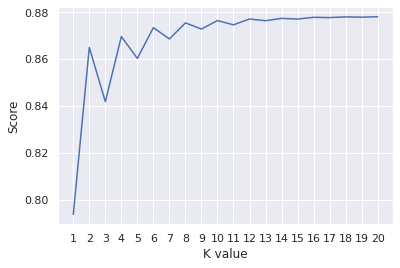

KNN best accuracy: 87.81%


In [ ]:
scoreListknn = []
for i in range(1,21):
    KNclassifier = KNeighborsClassifier(n_neighbors = i)
    KNclassifier.fit(X_train, y_train)
    scoreListknn.append(KNclassifier.score(X_test, y_test))
    
plt.plot(range(1,21), scoreListknn)
plt.xticks(np.arange(1,21,1))
plt.xlabel("K value")
plt.ylabel("Score")
plt.show()
KNAcc = max(scoreListknn)
print("KNN best accuracy: {:.2f}%".format(KNAcc*100))

**Support Vector Machine (SVM)**

In [ ]:
SVCclassifier = SVC(kernel='rbf', max_iter=500)
SVCclassifier.fit(X_train, y_train)

y_pred = SVCclassifier.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

from sklearn.metrics import accuracy_score
SVCAcc = accuracy_score(y_pred,y_test)
print('SVC accuracy: {:.2f}%'.format(SVCAcc*100))

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.89      0.63      0.74     44259
           1       0.14      0.43      0.21      6141

    accuracy                           0.61     50400
   macro avg       0.51      0.53      0.48     50400
weighted avg       0.80      0.61      0.68     50400

[[28071 16188]
 [ 3514  2627]]
SVC accuracy: 60.91%


**K-Means Clustering**

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0) 

kmeans.fit(X)

KMeans(n_clusters=2, random_state=0)

In [ ]:
kmeans.cluster_centers_

array([[1.88925000e+05, 2.09321960e+04, 2.89365750e+01, 1.00594931e+01,
        8.98271092e-01, 1.89090678e+00, 3.00160921e-01, 2.52220232e+01,
        1.58075276e+02, 1.38263878e+01, 6.32651071e+00, 1.99837494e+00],
       [6.29250001e+04, 2.09640846e+04, 2.89716093e+01, 1.01094389e+01,
        8.97537564e-01, 1.89253959e+00, 3.03017060e-01, 2.53315985e+01,
        1.58200221e+02, 1.37914756e+01, 6.34126070e+00, 1.99721099e+00]])

*   The KMeans algorithm clusters data by trying to separate samples in n groups of equal variances, minimizing a criterion known as inertia, or within-cluster sum-of-squares Inertia, or the within-cluster sum of squares criterion, can be recognized as a measure of how internally coherent clusters are.
*   The k-means algorithm divides a set of N samples X into K disjoint clusters C, each described by the mean j of the samples in the cluster. 
*   The means are commonly called the cluster centroids.
*   The K-means algorithm aims to choose centroids that minimize the inertia, or within-cluster sum of squared criterion.


Inertia
Inertia is not a normalized metric.

The lower values of inertia are better and zero is optimal.

But in very high-dimensional spaces, euclidean distances tend to become inflated (this is an instance of curse of dimensionality).

Running a dimensionality reduction algorithm such as PCA prior to k-means clustering can alleviate this problem and speed up the computations.

We can calculate model inertia as follows:-

In [ ]:
kmeans.inertia_

370216714855329.25

The lesser the model inertia, the better the model fit.

We can see that the model has very high inertia. So, this is not a good model fit to the data.

In [ ]:
labels = kmeans.labels_

# check how many of the samples were correctly labeled
correct_labels = sum(y == labels)

print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))

Result: 124872 out of 252000 samples were correctly labeled.


In [ ]:
print('Accuracy score: {0:0.2f}'. format(correct_labels/float(y.size)))

Accuracy score: 0.50


We have achieved a weak classification accuracy of 50% by our unsupervised model.

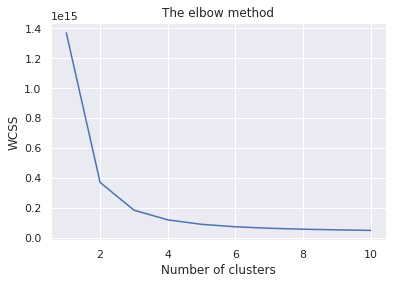

In [ ]:
#Finding the optimum number of clusters for k-means classification
from sklearn.cluster import KMeans
wcss = []

for i in range(1, 11):
  
    kmeans = KMeans(n_clusters = i, init = 'k-means++')
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++')
y_kmeans = kmeans.fit_predict(X)

In [ ]:
print(y_kmeans)

[0 0 0 ... 1 1 1]


In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2,random_state=0)

kmeans.fit(X)

labels = kmeans.labels_

# check how many of the samples were correctly labeled

correct_labels = sum(y == labels)

print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))

print('Accuracy score: {0:0.2f}'. format(correct_labels/float(y.size)))

Result: 124872 out of 252000 samples were correctly labeled.
Accuracy score: 0.50


In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0)

kmeans.fit(X)

# check how many of the samples were correctly labeled
labels = kmeans.labels_

correct_labels = sum(y == labels)
print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))
print('Accuracy score: {0:0.2f}'. format(correct_labels/float(y.size)))

Result: 88501 out of 252000 samples were correctly labeled.
Accuracy score: 0.35


In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0)

kmeans.fit(X)

# check how many of the samples were correctly labeled
labels = kmeans.labels_

correct_labels = sum(y == labels)
print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))
print('Accuracy score: {0:0.2f}'. format(correct_labels/float(y.size)))

Result: 59868 out of 252000 samples were correctly labeled.
Accuracy score: 0.24


**Gaussian NB**

In [ ]:
NBclassifier2 = GaussianNB()
NBclassifier2.fit(X_train, y_train)

y_pred = NBclassifier2.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

from sklearn.metrics import accuracy_score
NBAcc2 = accuracy_score(y_pred,y_test)
print('Gaussian Naive Bayes accuracy: {:.2f}%'.format(NBAcc2*100))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94     44259
           1       0.00      0.00      0.00      6141

    accuracy                           0.88     50400
   macro avg       0.44      0.50      0.47     50400
weighted avg       0.77      0.88      0.82     50400

[[44259     0]
 [ 6141     0]]
Gaussian Naive Bayes accuracy: 87.82%


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Decision Tree**

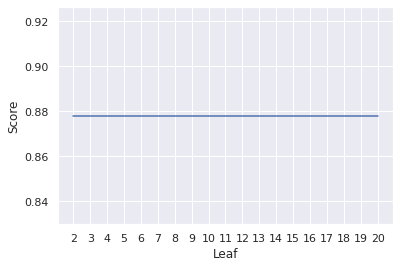

Decision Tree Accuracy: 87.82%


In [ ]:
scoreListDT = []
for i in range(2,21):
    DTclassifier = DecisionTreeClassifier(max_leaf_nodes=i)
    DTclassifier.fit(X_train, y_train)
    scoreListDT.append(DTclassifier.score(X_test, y_test))
    
plt.plot(range(2,21), scoreListDT)
plt.xticks(np.arange(2,21,1))
plt.xlabel("Leaf")
plt.ylabel("Score")
plt.show()
DTAcc = max(scoreListDT)
print("Decision Tree Accuracy: {:.2f}%".format(DTAcc*100))

**Gradient Boosting**

Xgboost

In [ ]:
paramsGB={'n_estimators':[100,200,300,400,500],
      'max_depth':[1,2,3,4,5],
      'subsample':[0.5,1],
      'max_leaf_nodes':[2,5,10,20,30,40,50]}

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier()

In [ ]:
preds2 = xgb.predict(X_test)

In [ ]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     44259
           1       0.68      0.46      0.55      6141

    accuracy                           0.91     50400
   macro avg       0.80      0.72      0.75     50400
weighted avg       0.90      0.91      0.90     50400



In [ ]:
accuracy_score(preds2, y_test)

0.8782936507936508

**Model** **Comparison**

In [ ]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
import xgboost

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier(),
    GradientBoostingClassifier(),
    GaussianNB()]

In [ ]:
accuracy = (959 + 0)/(959+0+58+5)
accuracy

0.9383561643835616

In [ ]:
recall = 959 / (959 + 5)
recall

0.9948132780082988

In [ ]:
precision = 959/(959 + 58)
precision

0.9429695181907571

In [ ]:
F1_Score = 2*(precision*recall)/(precision+recall)
F1_Score

0.9681978798586574